In [1]:
library("igraph")
library(R.utils)

Warning message:
"package 'igraph' was built under R version 3.4.4"
Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.7.1 (2016-02-15) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.21.0 (2016-10-30) successfully loaded. See ?R.oo for help.

Attaching package: 'R.oo'

The following object is masked from 'package:igraph':

    hierarchy

The following objects are masked from 'package:methods':

    getClasses, getMethods

The following objects are masked from 'package:base':

    attach, detach, gc, load, save

R.utils v2.5.0 (2016-11-07) successfully loaded. See ?R.utils for help.

Attaching package: 'R.utils'

The following object is masked from 'package:utils':

    timestamp

The following objects are masked from 'package:base':

    cat, commandArgs, getOption, inherit

In [2]:
ego_nodes <- c()

file_path = "gplus/"

for (circle_file in list.files(path = file_path, pattern = ".circles"))       
    if(length(readLines(paste(file_path, circle_file, sep = ""))) > 2)      
        ego_nodes <- c(ego_nodes, sub(".circles", "", circle_file))

printf(paste("#Users with more than 2 circles -", length(ego_nodes)))


#Users with more than 2 circles - 57

In [3]:
get_circles = function(node_id){
    
    circle_lines <- readLines(paste(file_path, node_id, ".circles", sep = ""))
    
    circles <- list()
    
    for(circle_nodes in circle_lines){
        
        list_of_nodes <- strsplit(circle_nodes, '\t')[[1]]

        circles[[list_of_nodes[1]]] <- list_of_nodes[2:(length(list_of_nodes))] #list_of_nodes[1] is the circle name

    }
    
    return(circles)
}

In [19]:
get_entropy = function(circle_community, N, circle_info = NULL){
    
    entropy <- 0
    el <- 0
    for(element in circle_community){

            if(is.null(circle_info))
                element_length <- length(element) / N
            else
                element_length <- length(intersect(element, circle_info)) / N
                
                
                
            el <- el + element_length
            if(element_length > 0)
                entropy <- entropy + (element_length) * log(element_length)
                

    }  
    if (is.null(circle_info))
        print(el)
    return(-entropy)
    
}

In [5]:
get_conditional_entropy_k_c = function(circles, communities, N, circle_info){
    
    
    conditional_entropy <- 0
    
    for(circ in circles){
        
        for(comm in communities){
                       
            common_people <- length(intersect(circ, comm))
            
            if(common_people > 0)
                conditional_entropy <- conditional_entropy + (common_people / N) * log(common_people / length(circ))
           
        }        
    }
    
    return(-conditional_entropy)
}

In [6]:
get_conditional_entropy_c_k = function(circles, communities, N, circle_info){
    
    
    conditional_entropy <- 0
    
    for(comm in communities){
        
        for(circ in circles){
                      
            common_people <- length(intersect(circ, comm))
            
            if(common_people > 0)
                conditional_entropy <- conditional_entropy + (common_people / N) * log(common_people / length(intersect(comm, circle_info)))
           
        }        
    }
    
    return(-conditional_entropy)
}

In [23]:
question_19 = function(node_id, plot = TRUE){
     
  edge_file <- paste("gplus/" , node_id  , ".edges" , sep="")

  ego_network <- read.graph(edge_file , format = "ncol" , directed=TRUE)  
  ego_network <- add.vertices(ego_network, nv = 1, name = node_id)
  ego_node_index <- which(V(ego_network)$name == node_id) 
  
  ego_edges <- c()
    
  for (vertex in 1:vcount(ego_network))
      if (vertex != ego_node_index)
        ego_edges <- c(ego_edges, c(ego_node_index, vertex))

  ego_network <- add_edges(ego_network, ego_edges)
  
  if(plot)
    plot(ego_network, vertex.size=1, vertex.label=NA, main = paste("Ego network for ID : ", node_id))
    
    out_degree <- degree(ego_network, v = V(ego_network), mode = c("out"))
    hist(out_degree, breaks = seq(from = 0, to = max(out_degree) + 1, by = 1), freq = F,
     main = 'Out degree distribution', xlab = "Degree")
    
    in_degree <- degree(ego_network, v = V(ego_network), mode = c("in"))
    hist(in_degree, breaks = seq(from = 0, to = max(in_degree) + 1, by = 1), freq = F,
     main = 'In degree distribution', xlab = "Degree")
 
  return(ego_network)

  
}


In [26]:
question_20 = function(ego_network, ego_node_id, plot = TRUE){
    
    community = walktrap.community(ego_network)
    
    node_size = rep(3, vcount(ego_network))
    
    ego_node_index <- which(V(ego_network)$name == ego_node_id) 
    
    node_size[ego_node_index] = 10
    
    if(plot){
        
        plot(community, ego_network, vertex.size = node_size, 
             vertex.label=NA, edge.lty = "blank", edge.arrow.mode = 0, mark.border = "black", 
             main = "Walk-trap community graph without edges")

        plot(community, ego_network, vertex.size = node_size, 
             vertex.label=NA, edge.lty = "dashed", edge.arrow.mode = 0.05, mark.border = "black",
             main = "Walk-trap community graph with edges")           
        
    }
    
 
    
    
    printf(paste("\nModularity of the community = ", modularity(community)))
    
    return(community)

    
}

In [30]:
question_22 = function(node_id, community){
    
    C <- get_circles(node_id)
    circles_set <- unique(unlist(C))
    N <- length(circles_set)
    K <- communities(community)

    circle_entropy <- get_entropy(C, N)
    print(paste('The circle entropy is', circle_entropy))
    community_entropy <- get_entropy(K, N, circle_info = circles_set)  
    print(paste('The community entropy is', community_entropy))

    ck_conditional_entropy <- get_conditional_entropy_c_k(C, K, N, circle_info =  circles_set)
    print(paste('The ck cond entropy is', ck_conditional_entropy))
    kc_conditional_entropy <- get_conditional_entropy_k_c(C, K, N, circle_info = circles_set)
    print(paste('The circle entropy is', kc_conditional_entropy))
    
    h <- 1 - (ck_conditional_entropy / circle_entropy)
    c <- 1 - (kc_conditional_entropy / community_entropy)
    
    printf(paste("\nHomogeneity = ", h))
    printf(paste("\nCompleteness = ", c))
    
    return(list(homogeneity = h, completeness = c))
    
    
    
}

In [10]:
ego_network_analysis = function(node_id, plot = TRUE){

    ego_network <- question_19(node_id, plot)
    community <- question_20(ego_network, node_id, plot)
    output <- question_22(node_id, community)
    
}

In [11]:
node_ids <- c("109327480479767108490", "115625564993990145546", "101373961279443806744")

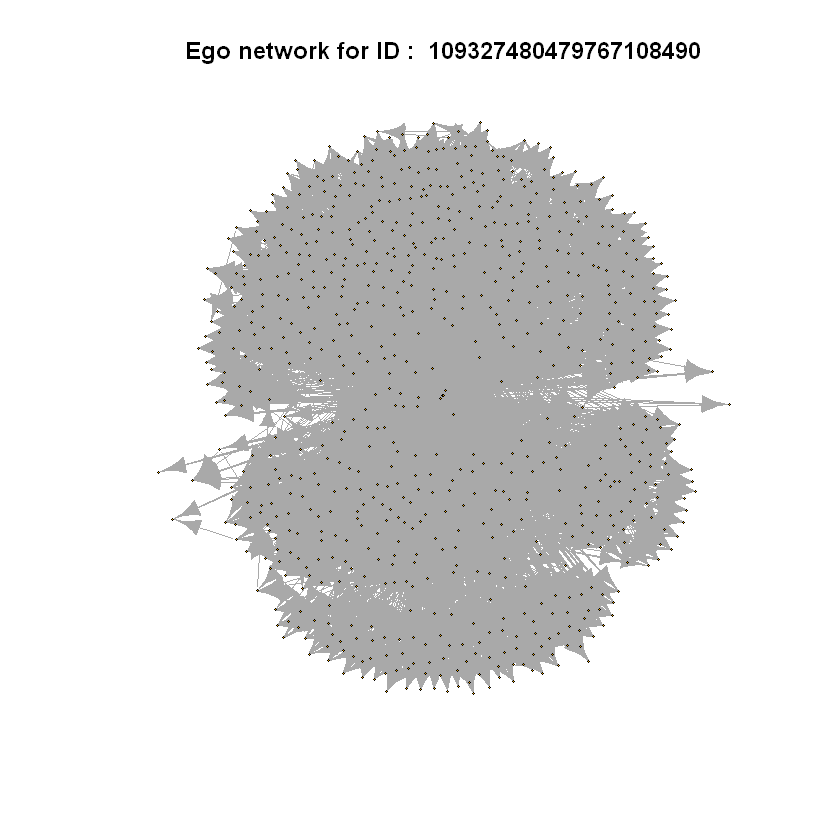

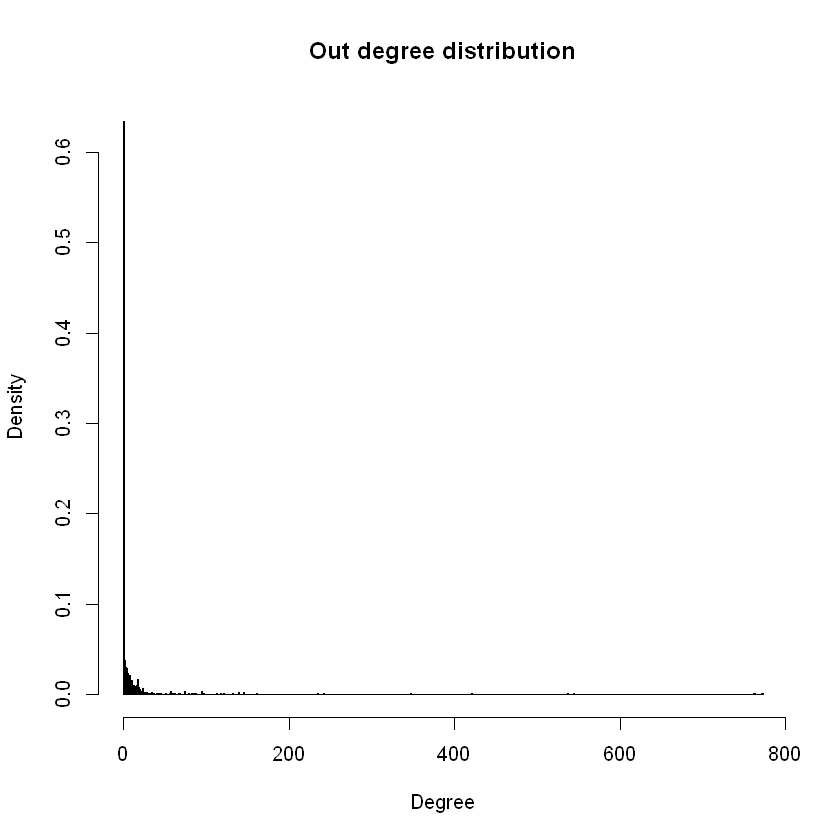

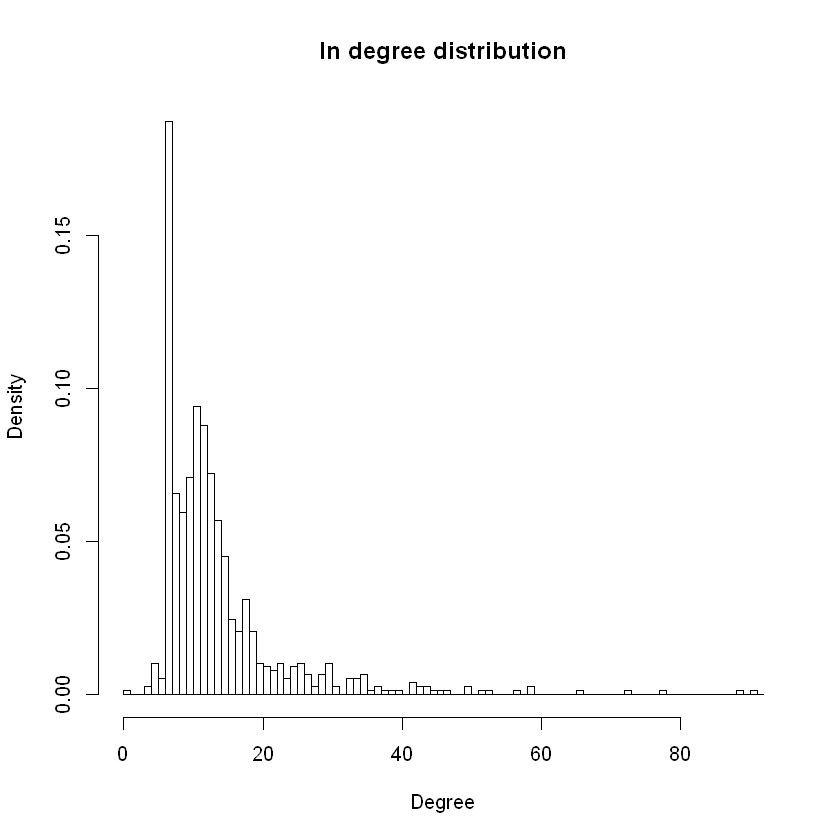

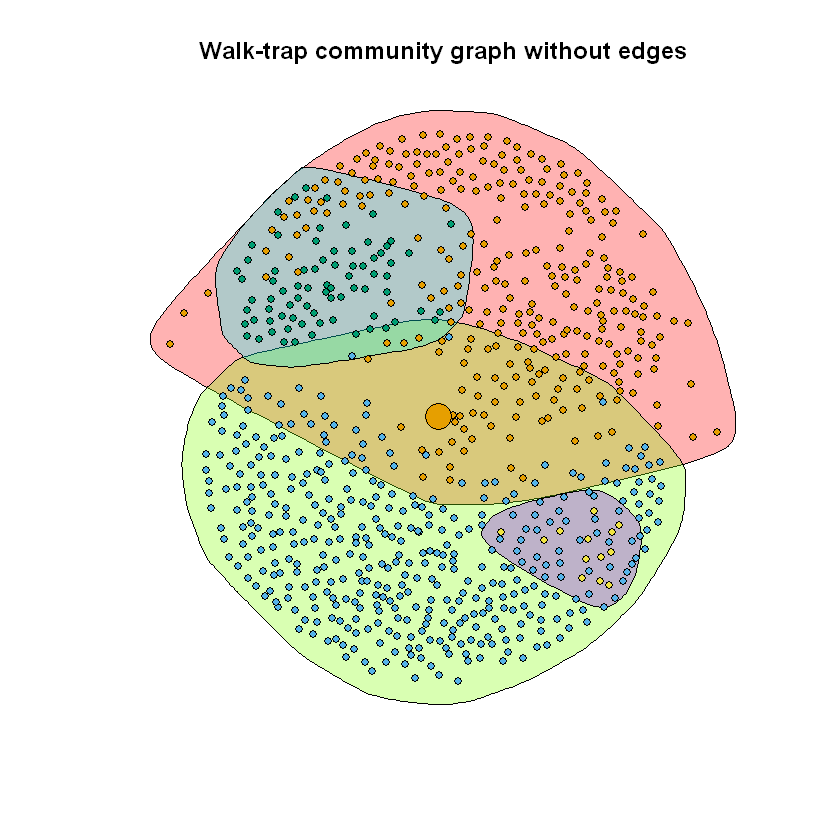


Modularity of the community =  0.252765387296677[1] 1.433246
[1] "The circle entropy is 1.05077934757594"
[1] "The community entropy is 1.00520818089008"
[1] "The ck cond entropy is 0.155636061763332"
[1] "The circle entropy is 0.673616224340775"

Homogeneity =  0.851885115440867
Completeness =  0.329873913536689

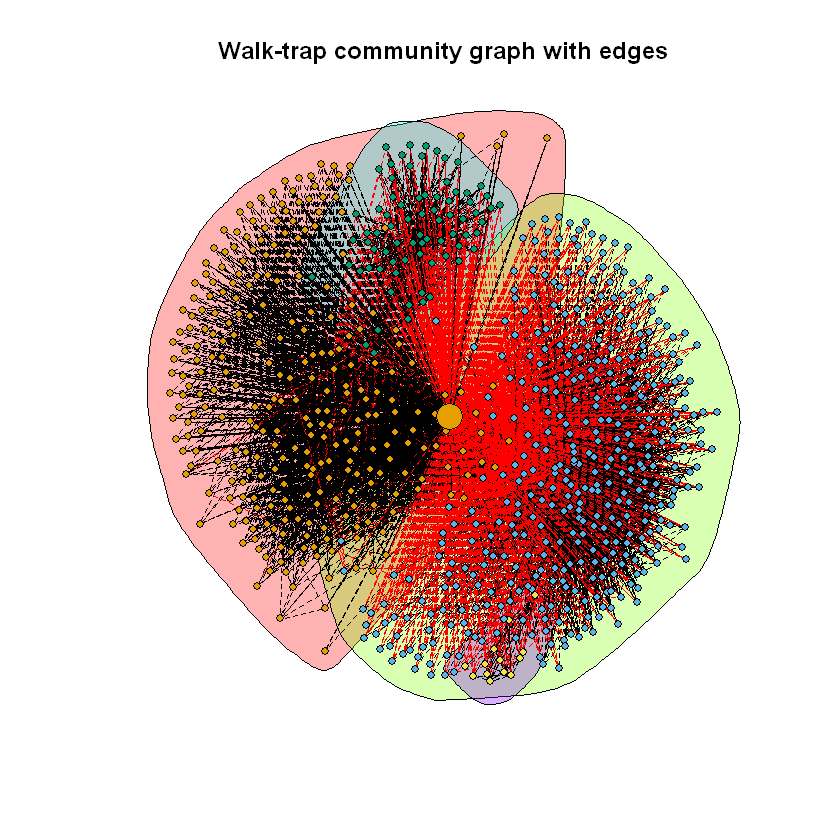

In [31]:
ego_network_analysis(node_ids[1])

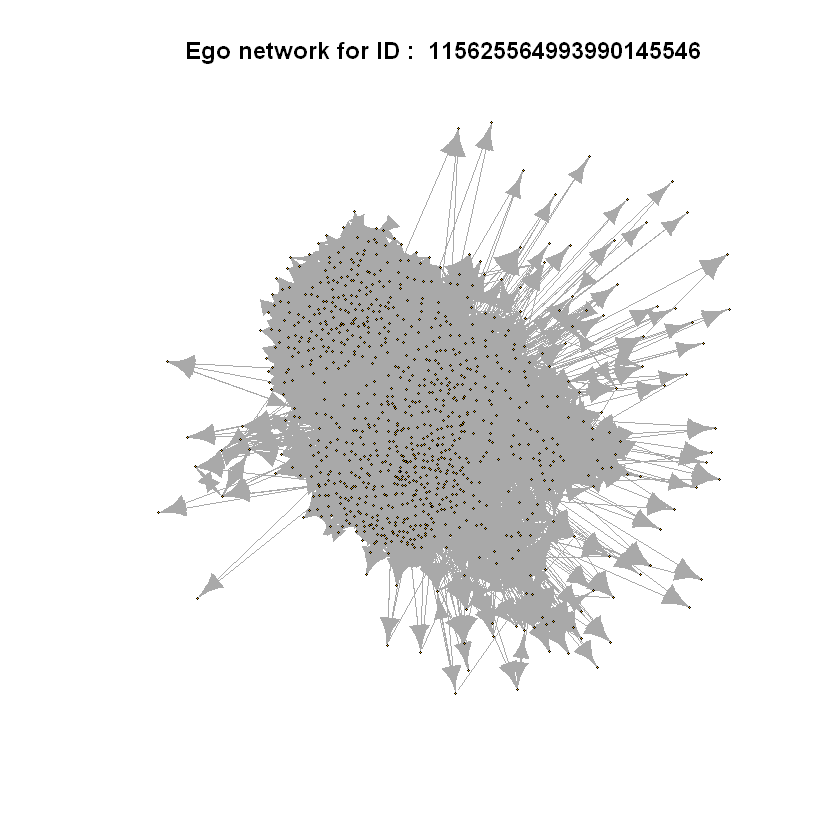

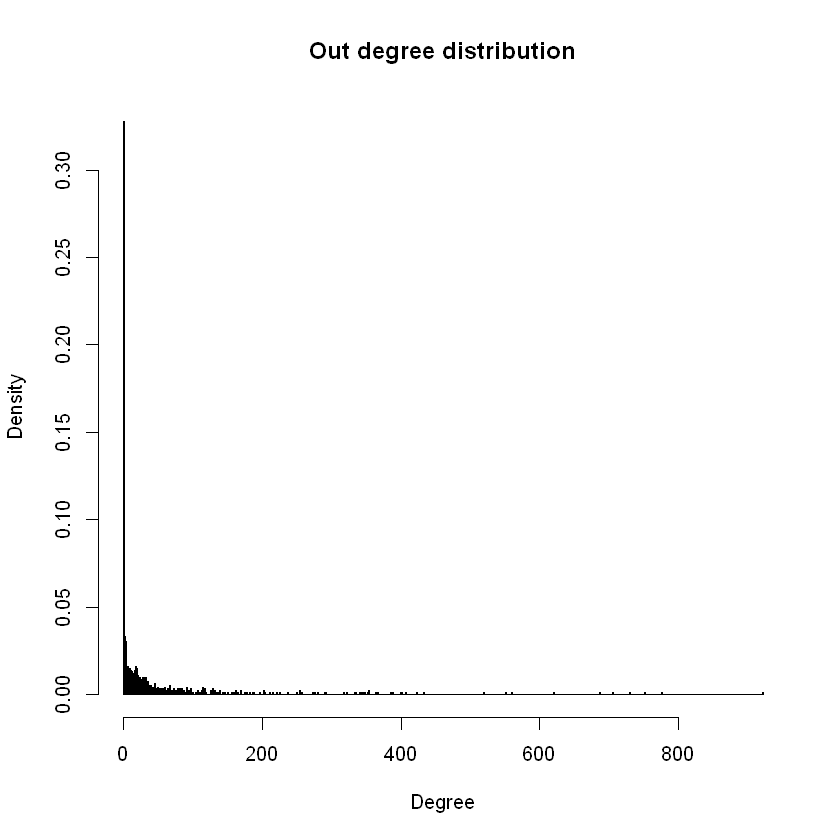

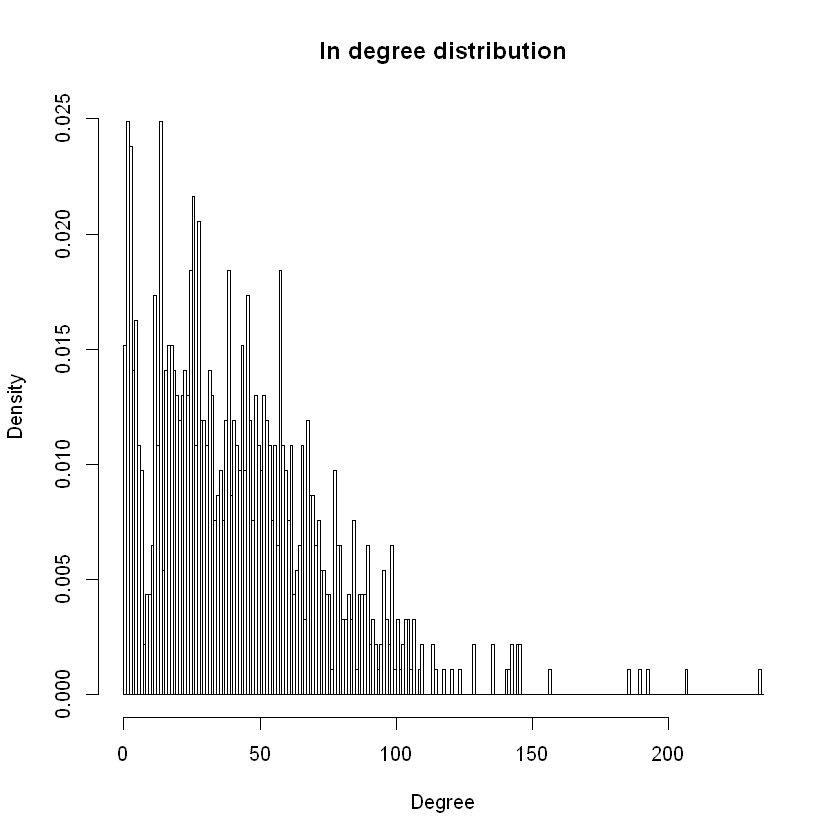

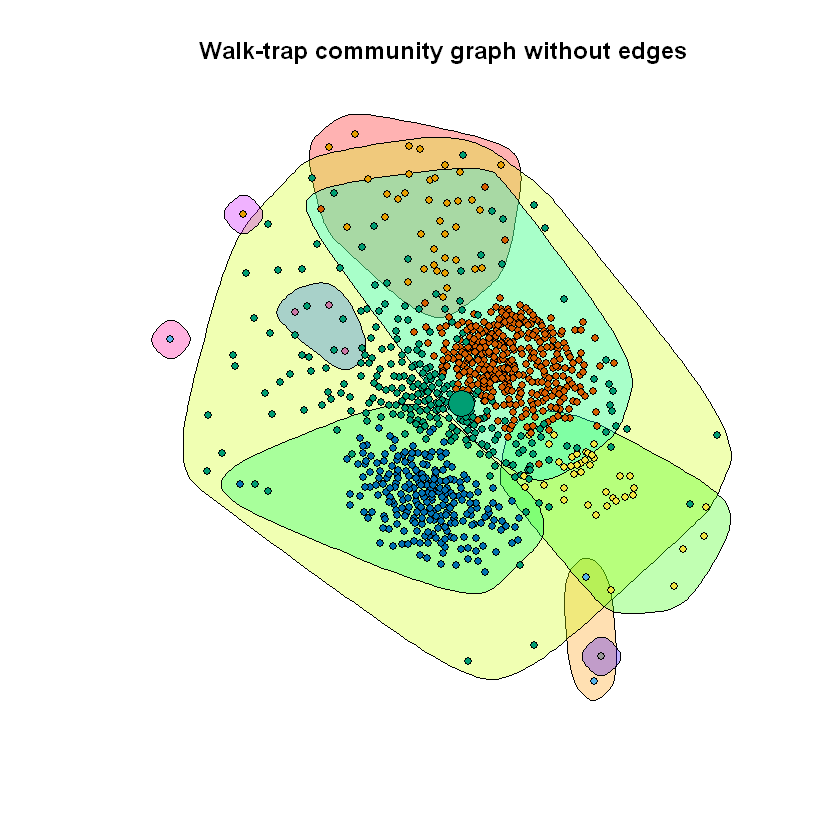


Modularity of the community =  0.319472551345825[1] 8.895461
[1] "The circle entropy is 8.46514668159249"
[1] "The community entropy is 1.08119096358335"
[1] "The ck cond entropy is 4.63982898243534"
[1] "The circle entropy is 4.78314811509253"

Homogeneity =  0.451890303032235
Completeness =  -3.4239623491117

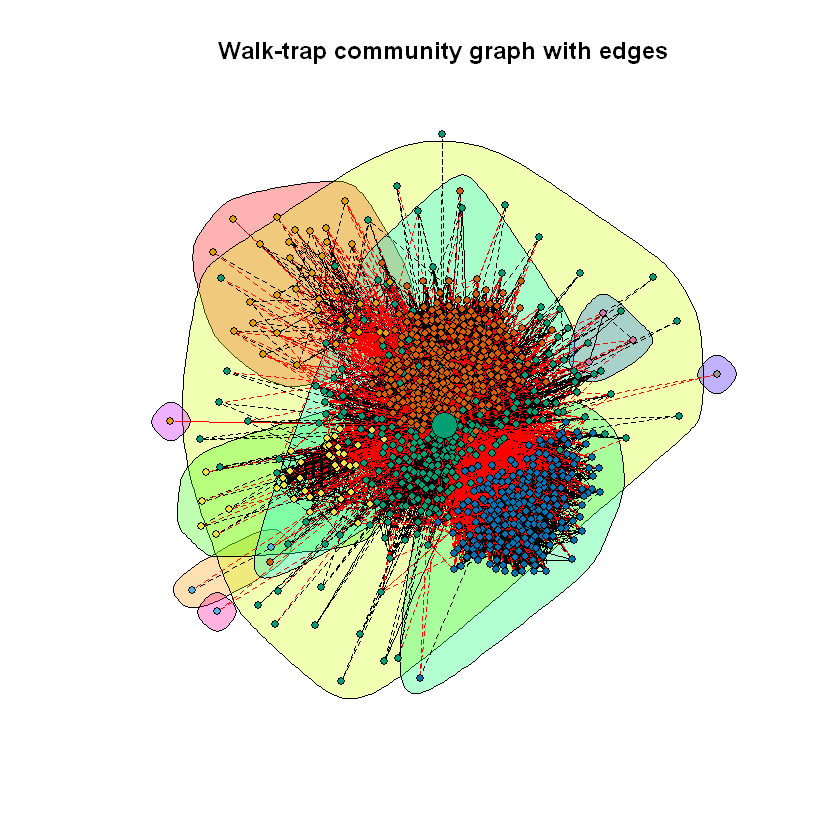

In [32]:
ego_network_analysis(node_ids[2])

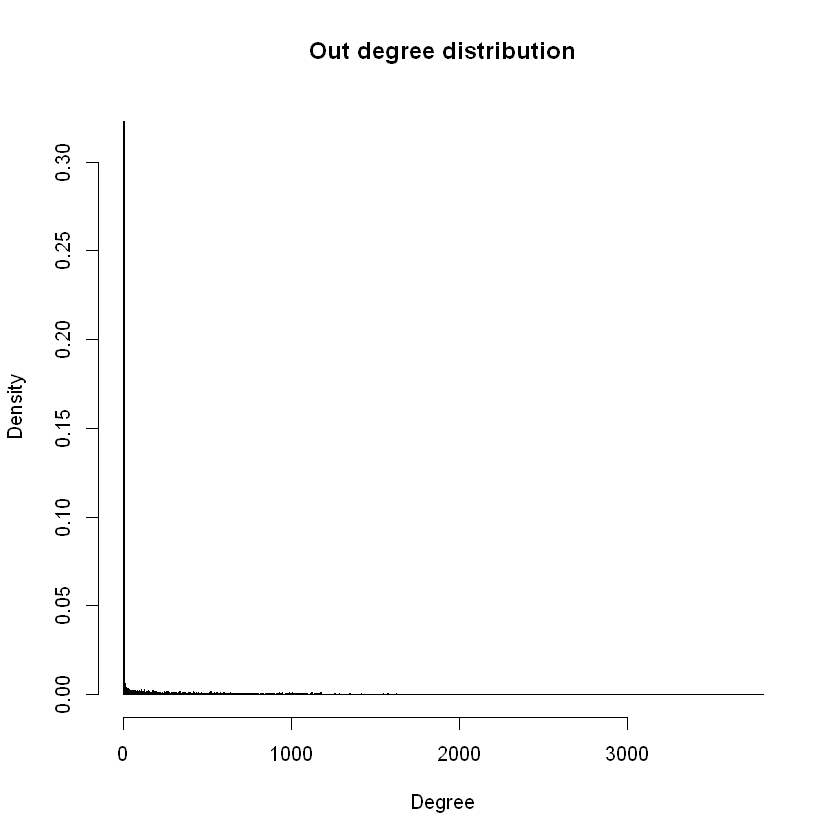


Modularity of the community =  0.191090270876884[1] 2.583493
[1] "The circle entropy is 0.384319958960942"
[1] "The community entropy is 0.493330612772394"
[1] "The ck cond entropy is 0.382833906292573"
[1] "The circle entropy is 1.23541745845449"

Homogeneity =  0.0038667069813052
Completeness =  -1.5042383879479

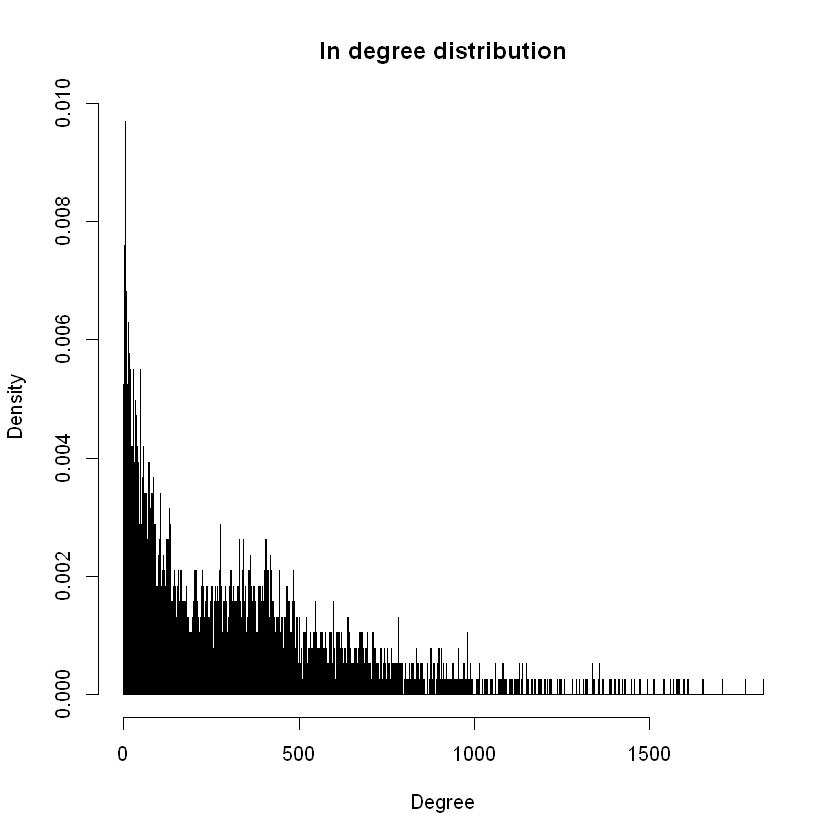

In [33]:
ego_network_analysis(node_ids[3], plot = FALSE)